In [9]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

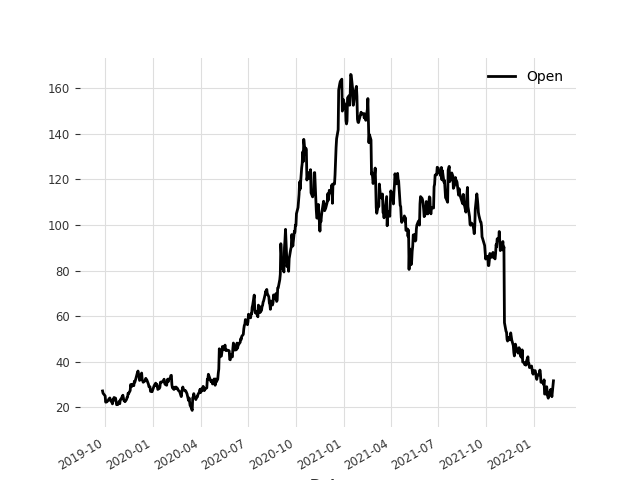

In [11]:
from os.path import abspath
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values

# Read /data/RBLX.csv as a pandas dataframe
df = pd.read_csv(abspath('../../../data/PTON/PTON.csv'), index_col=0)

# Convert the Data column to datetime
df.index = pd.to_datetime(df.index)

series = TimeSeries.from_dataframe(df, value_cols='Open', freq='B')
series = series.astype(np.float32)

series = fill_missing_values(series, fill="auto")

# Plot the series using a line graph
series.plot()

In [12]:
from darts.dataprocessing.transformers import Scaler

# Find the timestamp of the first 75% of df
first_75_percent = df.index[int(len(df) * 0.80)]

# Create training and test sets
train, val = series.split_after(pd.Timestamp(first_75_percent))

transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [13]:
from darts.models import TCNModel
from darts.utils.likelihood_models import GaussianLikelihood
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

deeptcn = TCNModel(
    dropout=0.2,
    batch_size=32,
    n_epochs=200,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    input_chunk_length=72,
    output_chunk_length=24,
    kernel_size=3,
    num_filters=4,
    model_name = 'PTON-DeepTCN',
    work_dir = abspath('../../../logs/PTON-DeepTCN-Noncovariant'),
    save_checkpoints = True,
    likelihood=GaussianLikelihood(),
    pl_trainer_kwargs={"callbacks": [stopper]}
)

In [14]:
deeptcn.fit(train_transformed, verbose=True)
deeptcn.save_model('/Users/aditya/Programming/stock-market-predictions/logs/PTON-DeepTCN-Noncovariant/model.pth.tar')

Epoch 199: 100%|██████████| 13/13 [00:00<00:00, 40.91it/s, loss=-1.15] 


In [15]:
backtest_en = deeptcn.historical_forecasts(
    series=series_transformed,
    num_samples=50,
    start=0.7,
    forecast_horizon=24,
    stride=5,
    retrain=False,
)

Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicting: 13it [00:00, ?it/s]
Predicti

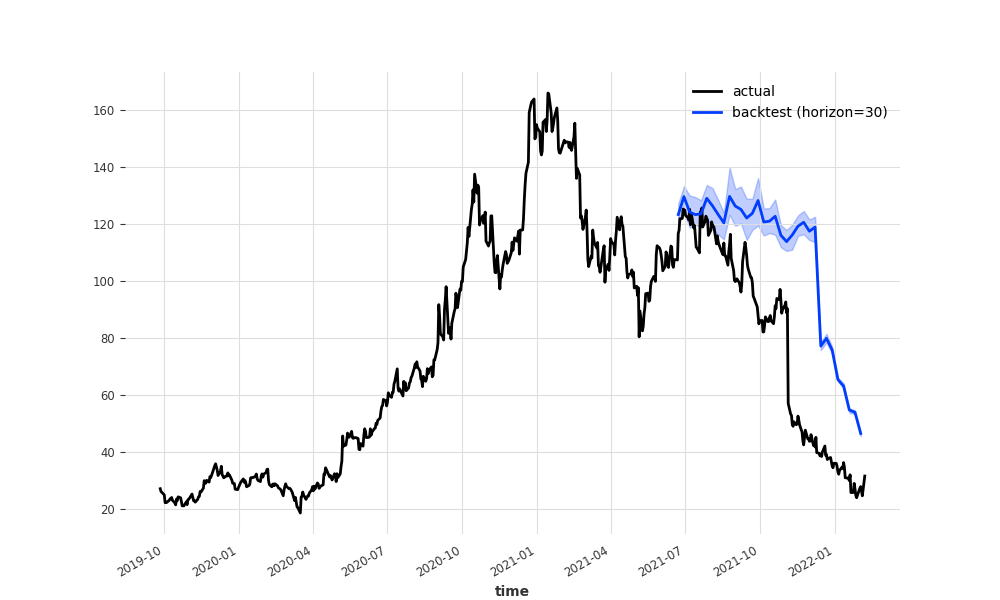

In [16]:
plt.figure(figsize=(10, 6))
transformer.inverse_transform(series_transformed).plot(label="actual")
transformer.inverse_transform(backtest_en).plot(label="backtest (horizon=30)", low_quantile=0.01, high_quantile=0.99)
plt.legend()